# 👣🖼️ -> 🖼️ Transferencia de Estilo Neuronal con control espacial en PyTorch




## 🧠 Idea principal

Normalmente, en la transferencia de estilo estándar:

    Se calcula la pérdida de estilo comparando los gram matrices de toda la imagen generada con la de la imagen de estilo.

    El estilo se aplica uniformemente sobre toda la imagen, sin distinguir regiones.

Con control espacial, puedes decir algo como:

    "Quiero que el cielo de esta imagen tenga el estilo del cielo de la pintura, pero que los árboles mantengan su forma original."

# 🔍 ¿Cómo se implementa?

Usualmente se usan máscaras binarias o máscaras suaves ([0, 1]) que especifican qué región se desea estilizar.

Ejemplo: máscara de estilo
   1 1 1 1 0 0 0 0
   1 1 1 1 0 0 0 0
   1 1 1 1 0 0 0 0
   1 1 1 1 0 0 0 0

En este caso, solo se aplica el estilo en la parte izquierda de la imagen.

En el código, esto se traduce a:

    Multiplicar las activaciones de estilo (y contenido) por la máscara (escalada al tamaño del feature map).

    Comparar solo las partes seleccionadas.

masked_feat = feature * resized_mask

🏗️ ¿Qué permite hacer?

    Transferencia de estilo localizada: diferentes estilos en distintas partes.

    Mejores resultados semánticos (por ejemplo, aplicar el estilo del cabello solo al cabello).

    Control artístico o técnico más fino.

# 🖼️ Ejemplo visual

Supón que quieres aplicar el estilo de Remedios Varo solo al fondo y dejar el objeto principal del contenido sin cambios. Puedes crear una máscara que:

    Sea 1 en el fondo.

    Sea 0 sobre el objeto principal.

Esto hace que la pérdida de estilo se calcule solo en el fondo.

## Variables, rutas y librerias

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

# Paths
content_path = "/content/ISIC_0024313.jpg"
style_path = "/content/ISIC_0024351.jpg"
content_mask_path = "/content/ISIC_0024313_segmentation.jpg"
style_mask_path = "/content/ISIC_0024351_segmentation.jpg"
img_size = (512, 512)

# GIF storage
result_frames = []
gradient_frames = []

# Carga de imágenes y máscaras


In [2]:
def load_image(path, title):
    image = Image.open(path).convert('RGB').resize(img_size)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 255),
        transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1, 1, 1])
    ])
    # Visualizar
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

    return transform(image).unsqueeze(0)

def deprocess_image(tensor):
    x = tensor.clone().detach().cpu().squeeze(0).numpy()
    x = x.transpose(1, 2, 0)
    x += [103.939, 116.779, 123.68]
    return np.clip(x[..., ::-1], 0, 255).astype('uint8')

def load_mask(path, title):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = (mask > 127).astype(np.float32)
    # Visualizar
    plt.figure(figsize=(4, 4))
    plt.imshow(mask, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    return torch.tensor(mask).unsqueeze(0).unsqueeze(0)

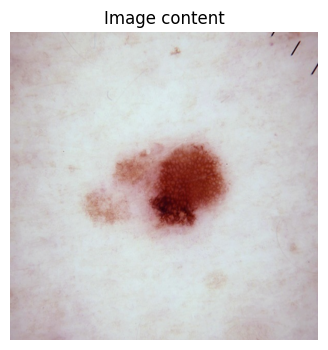

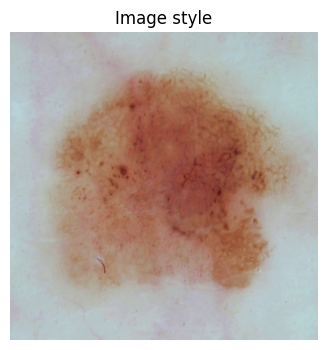

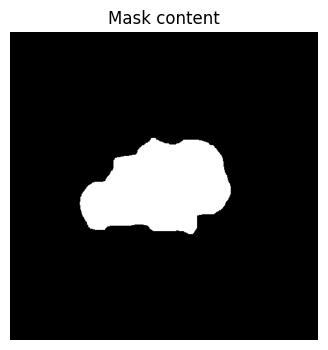

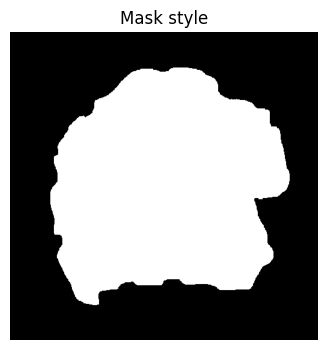

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
content_img = load_image(content_path, "Image content").to(device)
content_mask = load_mask(content_mask_path, "Mask content").to(device)
style_img = load_image(style_path, "Image style").to(device)
style_mask = load_mask(style_mask_path, "Mask style").to(device)

## Gram matriz

In [5]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    features = tensor.view(c, h * w)
    G = torch.mm(features, features.t())
    return G / (c * h * w)

### Gram vainilla vs Gram con control espacial

In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_gram(x):
    B, C, H, W = x.shape
    features = x.view(B, C, H * W)
    gram = torch.matmul(features, features.transpose(1, 2)) / (C * H * W)
    return gram[0]  # sacamos el batch

def compute_masked_gram(x, mask):
    B, C, H, W = x.shape
    mask = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
    x_masked = x * mask  # aplica la máscara a cada canal
    features = x_masked.view(B, C, H * W)
    gram = torch.matmul(features, features.transpose(1, 2)) / (C * H * W)
    return gram[0]

def visualize_gram_comparison(x, mask, name):
    gram_full = compute_gram(x)
    gram_masked = compute_masked_gram(x, mask)
    diff = (gram_full - gram_masked).abs()

    fig, axs = plt.subplots(1, 3, figsize=(8, 8))
    axs[0].imshow(gram_full.detach().cpu(), cmap='viridis')
    axs[0].set_title("Gram normal "+name)
    axs[1].imshow(gram_masked.detach().cpu(), cmap='viridis')
    axs[1].set_title("Gram enmascarada "+name)
    axs[2].imshow(diff.detach().cpu(), cmap='magma')
    axs[2].set_title("Diferencia |G - G_masked| "+name)

    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()

## Extraer características

In [23]:
# Load VGG19 model
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Define layers
layers_content = ['21']  # block4_conv2
layers_style = ['0', '5', '10', '19']  # conv1_1, conv2_1, conv3_1, conv4_1

In [24]:
# Extract features
def get_features(x, mask, model):
    features = []
    masked = []
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers_style + layers_content:
            features.append(x)
            m = nn.functional.interpolate(mask, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
            masked.append(x * m)
            visualize_gram_comparison(x, content_mask, name)
    return masked

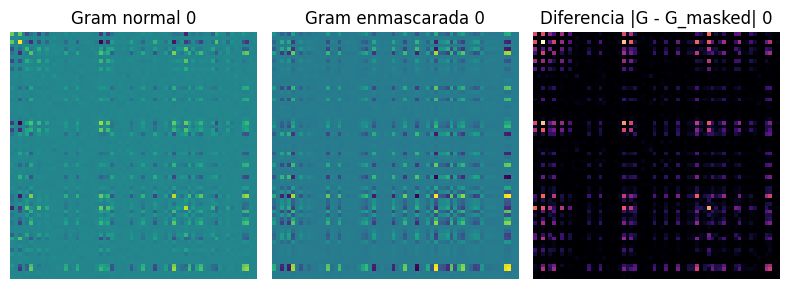

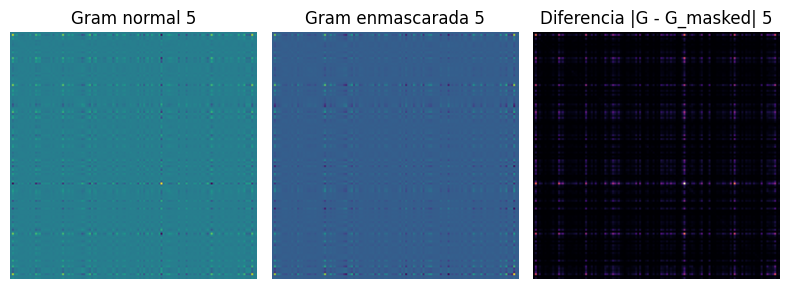

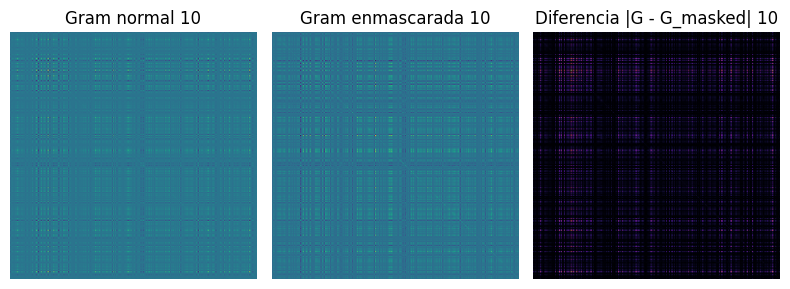

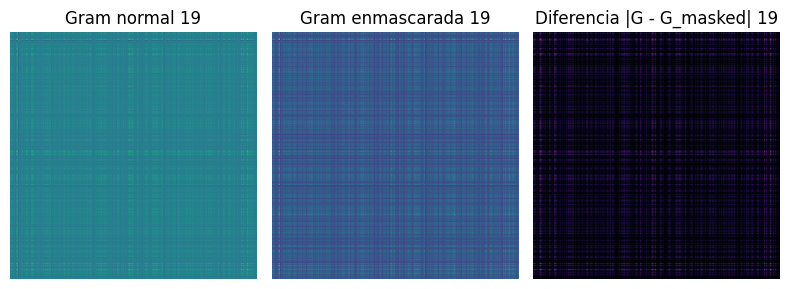

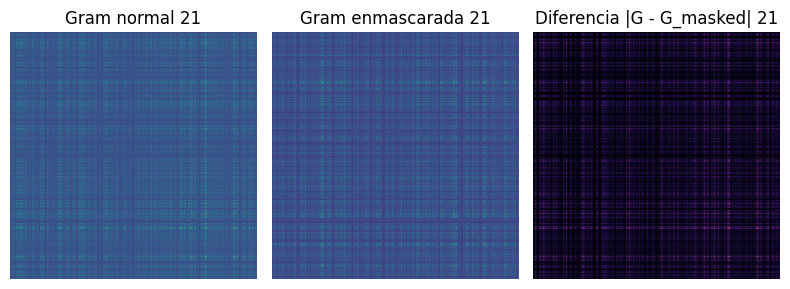

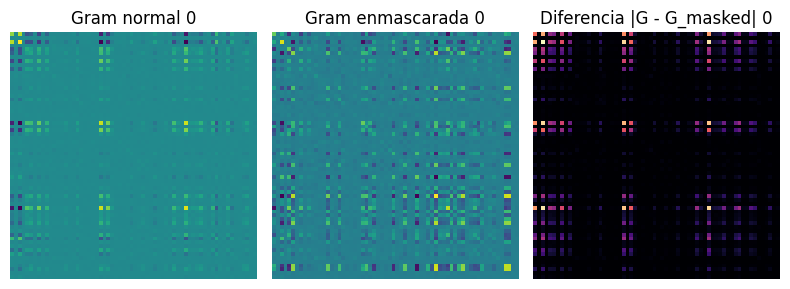

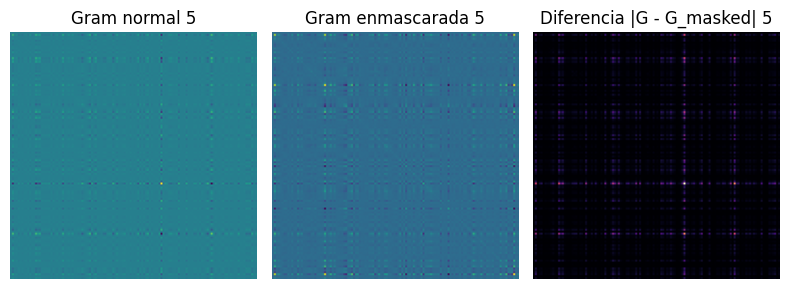

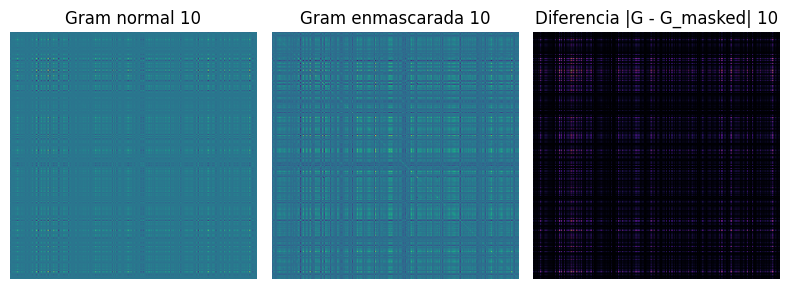

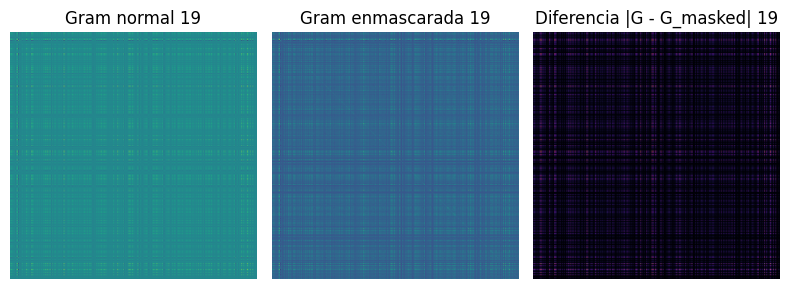

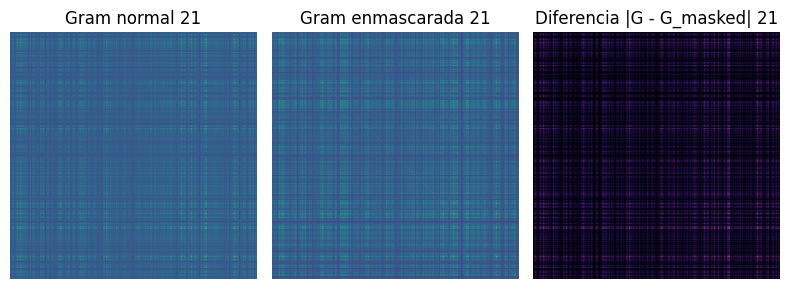

In [25]:
# Reference features
style_features = get_features(style_img, style_mask, vgg)[:len(layers_style)]
content_features = get_features(content_img, content_mask, vgg)[len(layers_style):]

In [26]:
# Generated image
generated = content_img.clone().requires_grad_(True)

## Optimización

In [10]:
# Loss and optimizer
style_weight = 1e-2
content_weight = 1e4
optimizer = optim.Adam([generated], lr=5.0)

In [11]:
# Training loop
for i in range(1000):
    optimizer.zero_grad()
    gen_features = get_features(generated, content_mask, vgg)
    gen_style = gen_features[:len(layers_style)]
    gen_content = gen_features[len(layers_style):]

    s_loss = sum(torch.mean((gram_matrix(gs) - gram_matrix(ss))**2)
                 for gs, ss in zip(gen_style, style_features)) * style_weight
    c_loss = sum(torch.mean((gc - cc)**2)
                 for gc, cc in zip(gen_content, content_features)) * content_weight
    total_loss = s_loss + c_loss
    total_loss.backward(retain_graph=True)

    # Save generated image and gradient for GIF
    with torch.no_grad():
        out_img = deprocess_image(generated)
        grad_img = deprocess_image(generated.grad if generated.grad is not None else torch.zeros_like(generated))
        result_frames.append(Image.fromarray(out_img))
        gradient_frames.append(Image.fromarray(grad_img))

    optimizer.step()

    if i % 50 == 0:
        print(f"Paso {i}, pérdida: {total_loss.item():.2f}")


Paso 0, pérdida: 10.68
Paso 50, pérdida: 340923.09
Paso 100, pérdida: 172902.62
Paso 150, pérdida: 133796.92
Paso 200, pérdida: 107496.14
Paso 250, pérdida: 109959.81
Paso 300, pérdida: 82915.67
Paso 350, pérdida: 72025.18
Paso 400, pérdida: 85048.53
Paso 450, pérdida: 61005.74
Paso 500, pérdida: 73540.61
Paso 550, pérdida: 143265.20
Paso 600, pérdida: 65633.88
Paso 650, pérdida: 46665.78
Paso 700, pérdida: 147946.78
Paso 750, pérdida: 152522.50
Paso 800, pérdida: 59029.99
Paso 850, pérdida: 53171.32
Paso 900, pérdida: 44925.30
Paso 950, pérdida: 96930.73


## Generar gif del resultado y gradientes

In [12]:
# Save GIFs
result_gif_path = "result.gif"
gradient_gif_path = "gradients.gif"
result_frames[0].save(result_gif_path, save_all=True, append_images=result_frames[1:], duration=100, loop=0)
gradient_frames[0].save(gradient_gif_path, save_all=True, append_images=gradient_frames[1:], duration=100, loop=0)

result_gif_path, gradient_gif_path

('result___aaaa.gif', 'gradients___aaaa.gif')